<center>
<strong>Задача:</strong> прогноз отказа мотора на следующем цикле.<br>
Считаем, что максимальный цикл мотора - это последний цикл перед поломкой.<br>
Нужно предложить варианты использования полученной модели на практике.<br>
<img src="description.png" />

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(17)
%matplotlib inline
from sklearn.metrics import f1_score, precision_recall_curve, auc, confusion_matrix
import math
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


In [4]:
print(data.shape)
data.info()

(16138, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
id       16138 non-null int64
cycle    16138 non-null int64
p00      16138 non-null float64
p01      16138 non-null float64
p02      16138 non-null float64
p03      16138 non-null float64
p04      16138 non-null float64
p05      16138 non-null float64
p06      16138 non-null float64
p07      16138 non-null float64
p08      16138 non-null int64
p09      16138 non-null int64
p10      16138 non-null int64
p11      16138 non-null float64
p12      16138 non-null float64
p13      16138 non-null float64
p14      16138 non-null float64
p15      16138 non-null float64
p16      16138 non-null float64
p17      16138 non-null float64
p18      16138 non-null float64
p19      16138 non-null float64
p20      16138 non-null float64
s1       16138 non-null float64
s2       16138 non-null float64
dtypes: float64(20), int64(5)
memory usage: 3.1 MB


In [5]:
data.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

Посмотрим на корреляции между признаками

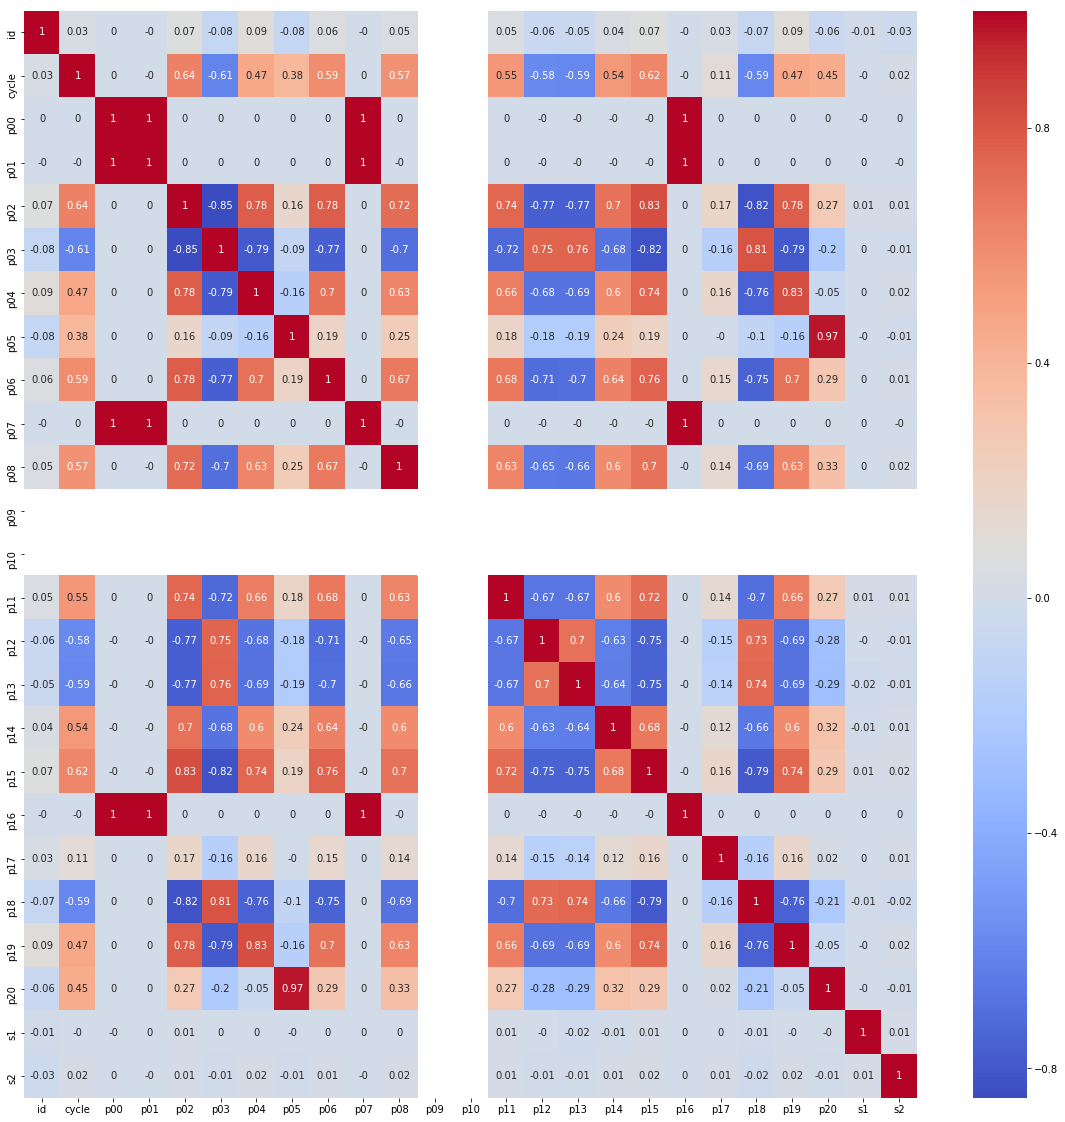

In [6]:
corr = data.corr(method='pearson').round(2)
plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True, cmap='coolwarm')

In [7]:
data[['p09', 'p10']].describe()

,p09,p10
count,16138.0,16138.0
mean,2388.0,100.0
std,0.0,0.0
min,2388.0,100.0
25%,2388.0,100.0
50%,2388.0,100.0
75%,2388.0,100.0
max,2388.0,100.0


Признаки p9 и p10 имеют стандартное отклонение равное 0, следовательно они не несут никакой информации для нас и их можно удалить.

In [8]:
data = data.drop(['p09', 'p10'], axis=1)

Также удалим сильно скоррелированные признаки

In [9]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of columns to delete
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

In [10]:
data = correlation(data, 0.9)
data.head()

,id,cycle,p00,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2
0,1,1,518.67,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,-0.0007,-0.0004
1,1,2,518.67,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,0.0019,-0.0003
2,1,3,518.67,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,-0.0043,0.0003
3,1,4,518.67,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,0.0007,0.0000
4,1,5,518.67,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,-0.0019,-0.0002


Посмотрим на целевой признак

Text(0, 0.5, 'Max cycle')

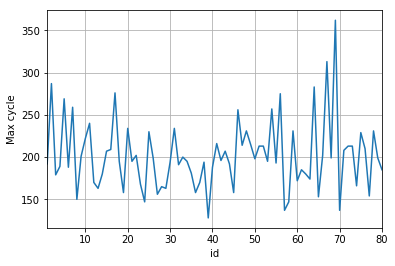

In [11]:
ax = data.groupby('id')['cycle'].max().plot(grid = True)
ax.set_ylabel('Max cycle')

Задача: предсказание вероятности того, что текущий цикл станет для мотора последним.
Предполагаем, что все моторы похожи
Делить данные на тренировочные и валидационные будем по id мотора (т.е. чтобы один мотор не присутствовал одновременно и в тренировочной выборке и в валидационной)

Создадим вектор ответов

In [12]:
a=[]
for i in data.id.unique():
    a.append(data[data.id == i].cycle.idxmax())

data['y'] = 0
for i in a:
    data.loc[i, 'y'] = 1

Разделим на train и test

In [13]:
data_id = data.id.unique()
np.random.shuffle(data_id)
train_id = data_id[:56] # 70% от общего кол-ва насосов
test_id = data_id[56:]

X_train = data[data.id.isin(train_id)].drop("y", axis = 1)
y_train = data[data.id.isin(train_id)]['y']

X_test = data[data.id.isin(test_id)].drop("y", axis = 1)
y_test = data[data.id.isin(test_id)]['y']

Попробуем сделать интуитивную модель вручную. Для этого будем просто постепенно увеличивать вероятность поломки после определенного номера цикла. В принципе "обучение" такой модели связано только подсчетом опорного значения и шага.

In [14]:
mean_cycles=[]
for i in X_train.id.unique():
    mean_cycles.append(X_train[X_train.id == i].cycle.mean())

# опорное значение после которого вероятность начинает расти
ref_val=np.mean(mean_cycles)

In [15]:
# Найдем шаг
max_cycles=[]
for i in X_train.id.unique():
    max_cycles.append(X_train[X_train.id == i].cycle.max())
    
step = math.floor(1/(np.max(max_cycles)- int(ref_val))*1000)/1000 + 0.0005

In [16]:
# Предсказание
prob = pd.Series(index=X_test.index)
for motor in X_test.id.unique():
    for i in X_test[X_test.id == motor].index:
        if X_test.cycle[i] < ref_val:
            prob[i] = 0
        else: prob[i] = prob[i-1] + step

Таким образом получаем вероятности отказа мотора на следующем цикле.

In [17]:
results = pd.concat([prob, y_test], axis=1, sort=False)
results.columns = ['prob', 'y']

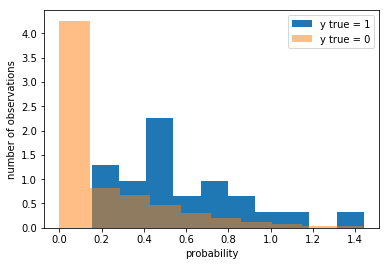

In [18]:
# plt.subplot(1,2,1)
plt.hist(results[results["y"] == 1]['prob'], density=True, label = 'y true = 1')
plt.hist(results[results["y"] == 0]['prob'], density=True, alpha = 0.5, label = 'y true = 0')
plt.xlabel('probability')
plt.ylabel('number of observations')
plt.legend();

Разброс длины цикла в тестовой выборке очень большой. Выбиререм порог 0.2, чтобы точно вовремя снять мотор с эксплуатации. Моторы с большим кол-вом циклов, чем в обучающей выборке попали в тестовую, поэтому появились вероятности > 1.

In [19]:
y_pred = []
for i in results.index:
    if results.prob[i] > 0.2:
        y_pred.append(1) 
    else: y_pred.append(0)
results['y_pred'] = y_pred

In [20]:
f1_score(results.y, results.y_pred)

0.026497695852534562

Перейдем к нормальным моделям. Для начала попробуем модели основанные на деревьях решений, потому что они не требуют нормализации данных.

In [21]:
models_scores = {}

# Decision Tree

In [22]:
dt = DecisionTreeClassifier()
param_grid = {'max_depth':[5, 10, 15, 20, 25, 50],
    'min_samples_split':[2, 10, 15],
    'max_features':[None, 'log2', 'sqrt', 15, 10]}
grid_search = GridSearchCV(dt, param_grid, cv=10)

grid_search.fit(X_train, y_train)
print('best parameters:', grid_search.best_params_)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
prob = best_dt.predict_proba(X_test)

best parameters: {'max_depth': 5, 'max_features': 10, 'min_samples_split': 10}


In [23]:
results = pd.DataFrame(y_test, columns=['y'], index=y_test.index)
results['prob'], results['y_pred'] = prob[:, 1], y_pred

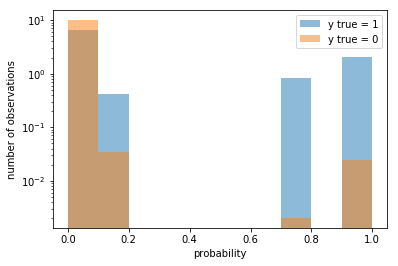

In [24]:
plt.hist(results[results["y"] == 1]['prob'], density=True, alpha = 0.5, label = 'y true = 1')
plt.hist(results[results["y"] == 0]['prob'], density=True, alpha = 0.5, label = 'y true = 0')
plt.xlabel('probability')
plt.ylabel('number of observations')
plt.yscale('log')
plt.legend();

In [25]:
TPR = results[(results.y == 1) & (results.y_pred == 1)].shape[0]/results[results.y == 1].shape[0]
print('TPR: ', TPR, '\n', results.y_pred.value_counts())

TPR:  0.2916666666666667 
 0    4948
1      20
Name: y_pred, dtype: int64


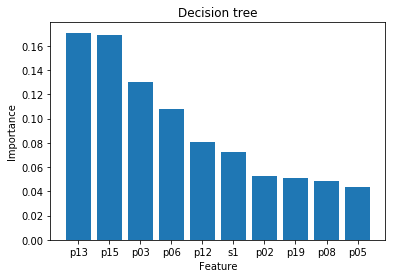

In [26]:
dt_features = pd.DataFrame({'feature': X_train.columns, 'importance': best_dt.feature_importances_}).sort_values(by=['importance'], ascending=False)
x = np.arange(10)
plt.bar(x, dt_features['importance'][:10])
plt.xticks(x, list(dt_features.feature[:10]))
plt.title('Decision tree')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.plot();

In [27]:
dt_score = f1_score(results.y, results.y_pred)

In [28]:
models_scores.update( {'Decision Tree' : dt_score} )

Эта модель очень простая, попробуем что-нибудь сложней

# Random Forest

In [29]:
def model_results(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        prob = model.predict_proba(X_test)
        results = pd.DataFrame({'y': y_test, 'prob':prob[:, 1], 'y_pred':y_pred}, index=y_test.index)
    except:
        results = pd.DataFrame({'y': y_test, 'y_pred':y_pred}, index=y_test.index)
    return results

In [30]:
rf = RandomForestClassifier()
results = model_results(rf, X_train, y_train, X_test, y_test)
rf_score = f1_score(results.y, results.y_pred)
models_scores.update( {'Random Forest' : rf_score} )
rf_score

0.0

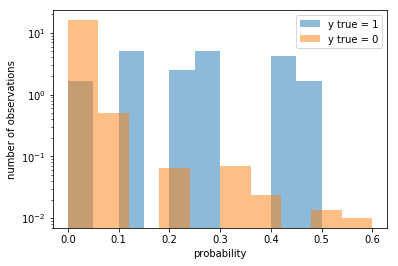

In [31]:
def y_true_distrib(results): 
    plt.hist(results[results["y"] == 1]['prob'], density=True, alpha = 0.5, label = 'y true = 1')
    plt.hist(results[results["y"] == 0]['prob'], density=True, alpha = 0.5, label = 'y true = 0')
    plt.xlabel('probability')
    plt.ylabel('number of observations')
    plt.yscale('log')
    plt.legend();
y_true_distrib(results)

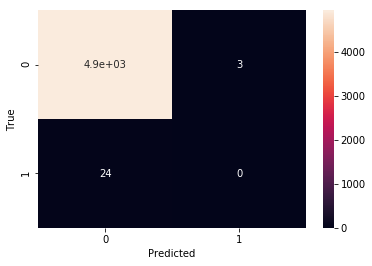

In [32]:
def conf_matr(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax);
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show();
conf_matr(y_test, results.y_pred)

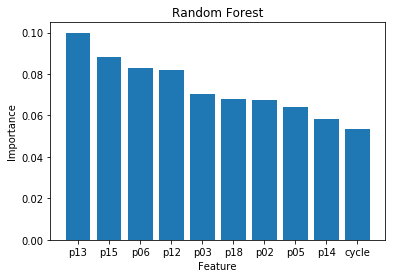

In [33]:
def plot_feature_importance(model, name, X_train):
    features = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_}).sort_values(by=['importance'], ascending=False)
    x = np.arange(10)
    plt.bar(x, features['importance'][:10])
    plt.xticks(x, list(features.feature[:10]))
    plt.title(name)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.plot();
plot_feature_importance(rf, 'Random Forest', X_train)

# Нормализация данных

Нормализация нужна для того, чтобы вне зависимости от диапазона значений вклады признаков были одинаковые.

In [34]:
scaler = StandardScaler()
scaler.fit(X_train.drop(labels=['id', 'cycle'], axis=1))

X_train_scaled = pd.DataFrame(scaler.transform(X_train.drop(labels=['id', 'cycle'], axis=1)),
                              index=X_train.drop(labels=['id', 'cycle'], axis=1).index, 
                              columns=X_train.drop(labels=['id', 'cycle'], axis=1).columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop(labels=['id', 'cycle'], axis=1)),
                              index=X_test.drop(labels=['id', 'cycle'], axis=1).index, 
                              columns=X_test.drop(labels=['id', 'cycle'], axis=1).columns)

X_train_scaled = pd.concat([X_train[['id', 'cycle']], X_train_scaled], axis=1)
X_test_scaled = pd.concat([X_test[['id', 'cycle']], X_test_scaled], axis=1)

# Lightgbm

In [35]:
lgbm_model = lgbm.LGBMClassifier()
results = model_results(lgbm_model, X_train_scaled, y_train, X_test_scaled, y_test)
lgbm_score = f1_score(results.y, results.y_pred)
models_scores.update( {'Lightgbm' : lgbm_score} )
lgbm_score

0.3684210526315789

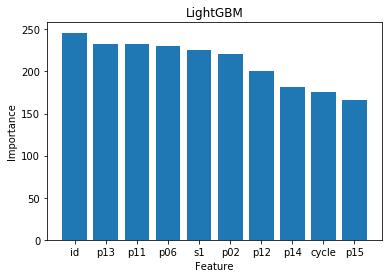

In [36]:
plot_feature_importance(lgbm_model, 'LightGBM', X_train_scaled)

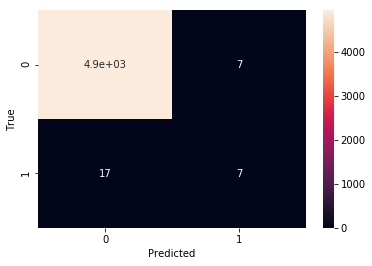

In [37]:
conf_matr(y_test, results.y_pred)

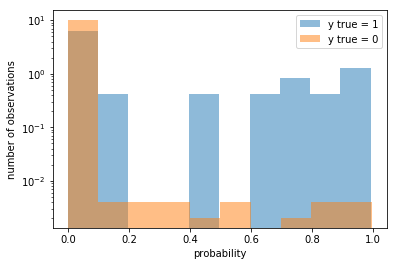

In [38]:
y_true_distrib(results)

# XGBoost

In [39]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
results = model_results(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)
xgb_score = f1_score(results.y, results.y_pred)
models_scores.update( {'XGBoost' : xgb_score} )
xgb_score

0.1875

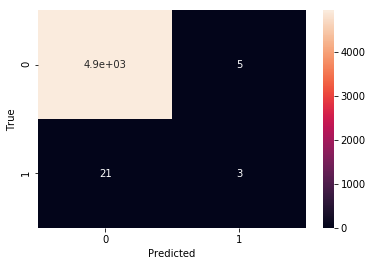

In [40]:
conf_matr(y_test, results.y_pred)

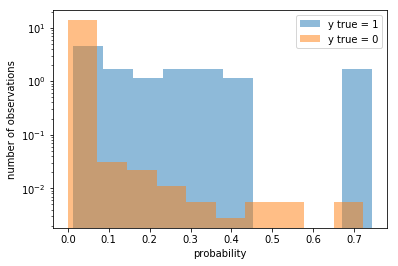

In [41]:
y_true_distrib(results)

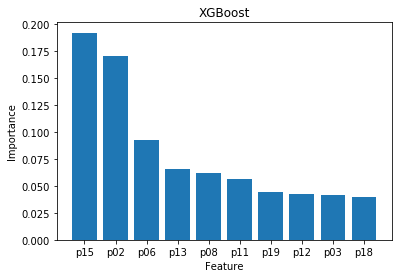

In [42]:
plot_feature_importance(xgb_model, 'XGBoost', X_train_scaled)

# CatBoost

In [43]:
cat = CatBoostClassifier(verbose=False)
results = model_results(cat, X_train_scaled, y_train, X_test_scaled, y_test)
cat_score = f1_score(results.y, results.y_pred)
models_scores.update( {'CatBoost' : cat_score} )
cat_score

0.3125

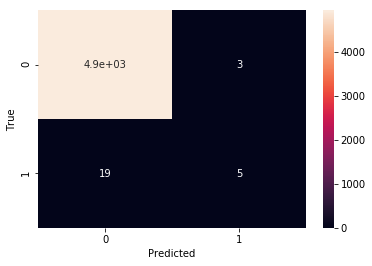

In [44]:
conf_matr(y_test, results.y_pred)

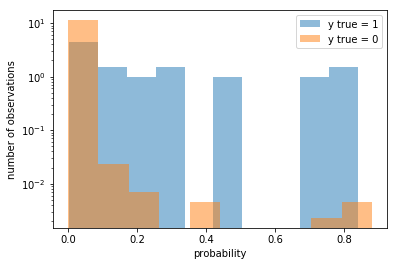

In [45]:
y_true_distrib(results)

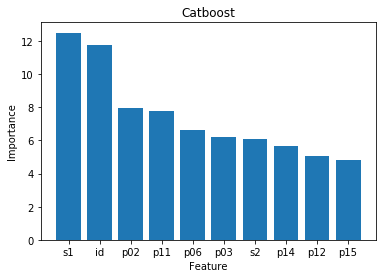

In [46]:
plot_feature_importance(cat, 'Catboost', X_train_scaled)

# Логистическая регрессия

In [47]:
lr = LogisticRegression()
results = model_results(lr, X_train_scaled, y_train, X_test_scaled, y_test)
lr_score = f1_score(results.y, results.y_pred)
models_scores.update( {'Logistic Regression' : lr_score} )
lr_score

0.3125

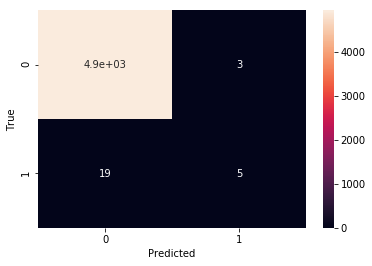

In [48]:
conf_matr(y_test, results.y_pred)

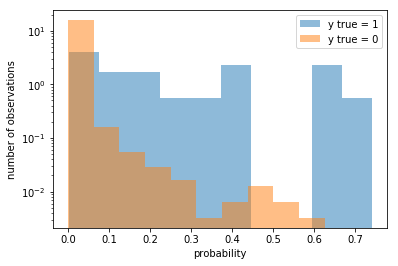

In [49]:
y_true_distrib(results)

# kNN

Для многих алгоритмов дисбаланс классов является довольно большой проблемой, но kNN не учитывает никак колличество объектов в каждом классе, смотрит только на то, к какому классу относятся соседи из обучающей выборки.

In [50]:
kNN = KNeighborsClassifier(n_neighbors=1)
results = model_results(kNN, X_train_scaled, y_train, X_test_scaled, y_test)
knn_score = f1_score(results.y, results.y_pred)
models_scores.update( {'kNN' : knn_score} )
knn_score

0.08695652173913045

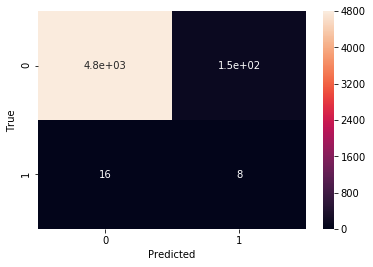

In [51]:
conf_matr(y_test, results.y_pred)

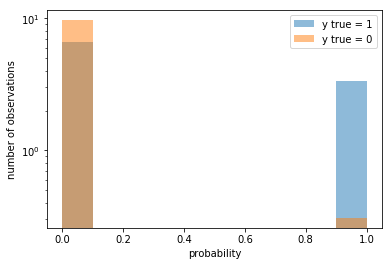

In [52]:
y_true_distrib(results)

# SVM

In [53]:
svm = SVC(kernel='linear', gamma='scale')
results = model_results(svm, X_train_scaled, y_train, X_test_scaled, y_test)
svm_score = f1_score(results.y, results.y_pred)
models_scores.update( {'SVM' : svm_score} )
svm_score

0.07999999999999999

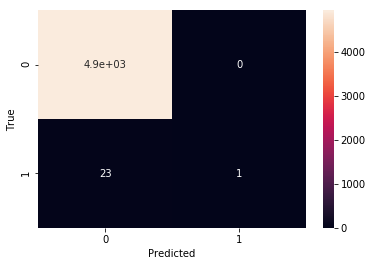

In [54]:
conf_matr(y_test, results.y_pred)

# Выберем лучшую модель

In [55]:
# models_results_df = pd.DataFrame(models_scores)
models_results_df = pd.DataFrame.from_dict(models_scores, orient='index', columns=['score'])
models_results_df.sort_values(by=['score'], ascending=False)

,score
Lightgbm,0.368421
Decision Tree,0.318182
CatBoost,0.312500
Logistic Regression,0.312500
XGBoost,0.187500
kNN,0.086957
SVM,0.080000
Random Forest,0.000000


Лучшей моделью оказался Lightgbm, поэтому финальное предсказание сделаем на ней

In [56]:
lgbm_model = lgbm.LGBMClassifier()
results = model_results(lgbm_model, X_train_scaled, y_train, X_test_scaled, y_test)

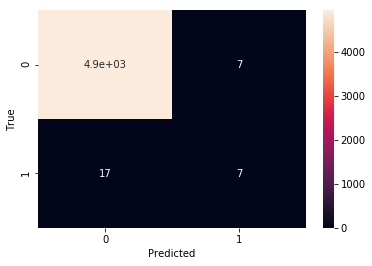

In [57]:
conf_matr(y_test, results.y_pred)

In [58]:
results[results.y == 1]

,y,prob,y_pred
478,1,0.000111,0
846,1,0.053967,0
1562,1,0.054644,0
1712,1,0.000401,0
2375,1,0.914981,1
3304,1,0.005074,0
3775,1,0.489824,0
4732,1,0.737946,1
5629,1,0.096198,0
6220,1,0.002020,0


# Предсказание

In [59]:
prediction = pd.concat([X_test, results.prob.round(2)], axis=1, sort=False)
# ну или в качестве ответов
results.prob.round(2)

192      0.00
193      0.00
194      0.00
195      0.00
196      0.00
         ... 
15948    0.00
15949    0.00
15950    0.00
15951    0.00
15952    0.03
Name: prob, Length: 4968, dtype: float64

Дальнейшие действия:
* параметры s0 и s1 - устанавливаются после того, как мотор отработал цикл и влияют на следующий цикл, значит их можно сдвинуть на один цикл вперед
* автоматизировать выбор модели
* настройка гиперпараметров лучшей модели
* предсказание вероятности поломки на следующем цикле учитывая k предыдущих циклов (сейчас учитываем данные только об одном цикле)
* Так же данные по одному мотору - пример временного ряда, надо попробовать анализировать их с помощью методов разработанных специально для такого типа данных

Варианты использования полученной модели:
* Предсказание вероятности поломки мотора на следующем цикле (чтобы вовремя снимать мотор с эксплуатации)

Альтернативная постановка задачи:
* Предсказание номера последнего цикла работы мотора (т.е. не сломается ли мотор на следующем цикле, а когда он сломается)
* Оценка качества мотора